# HEADWAYS ANALYSIS

In [1]:
import pandas as pd

import numpy as np
from numpy import pi, sin, cos

import json

import datetime
from datetime import timedelta

import statistics
from statistics import mean
import math

from pandarallel import pandarallel
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
pandarallel.initialize()

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
pio.templates.default = 'plotly_white'
pd.set_option("display.precision", 3)

import matplotlib

import scipy
from scipy import stats
from scipy.spatial.distance import mahalanobis
import statsmodels.api as sm
import pylab
from scipy.stats.distributions import chi2

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
#Available colors
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]

In [3]:
# FUNCTIONS 
def headways_2d(df):
    times,busesA,busesB,busesC,h12,h23 = [],[],[],[],[],[]
    burst_times = df.datetime.unique()
    for burst_time in burst_times :
        time_df1 = df.loc[(df.datetime == burst_time) & (df.direction == 1)]
        time_df2 = df.loc[(df.datetime == burst_time) & (df.direction == 2)]
        
        for i in range(max(time_df1.shape[0],time_df2.shape[0])) :
            if i < (time_df1.shape[0] - 1) :
                times.append(burst_time)
                busesA.append(time_df1.iloc[i].busA)
                busesB.append(time_df1.iloc[i].busB)
                busesC.append(time_df1.iloc[i+1].busB)
                h12.append(time_df1.iloc[i].headway)
                h23.append(time_df1.iloc[i+1].headway)
            if i < (time_df2.shape[0] - 1) :
                times.append(burst_time)
                busesA.append(time_df2.iloc[i].busA)
                busesB.append(time_df2.iloc[i].busB)
                busesC.append(time_df2.iloc[i+1].busB)
                h12.append(time_df2.iloc[i].headway)
                h23.append(time_df2.iloc[i+1].headway)
    
                
    return pd.DataFrame({'time':times ,'busA': busesA, 'busB': busesB, 'busC': busesC, 'h12': h12, 'h23': h23})

def conf_ellipse_params(df,conf) :
    col1 = df['h12']
    col2 = df['h23']
    
    #Mean values for the center of the ellipse
    mu1 = col1.mean()
    mu2 = col2.mean()
    mus = [mu1,mu2]
    
    # Columns covariance matrix
    cov_mat = np.stack((col1, col2), axis = 0)  
    cov_matrix = np.cov(cov_mat)
    
    a = cov_matrix[0][0]
    b = cov_matrix[0][1]
    c = cov_matrix[1][1]
    
    lambda1 = (a+c)/2 + math.sqrt(((a-c)/2)**2 + b**2)
    lambda2 = (a+c)/2 - math.sqrt(((a-c)/2)**2 + b**2)
    
    #Rotation angle
    if (b == 0) and (a >= c) :
        theta = 0
    elif (b == 0) and (a < c) :
        theta = math.pi/2
    else :
        theta = math.atan2(lambda1-a,b)
    
    #Eigenvectors
    ei_vecs = [
        [math.cos(theta),-math.sin(theta)],
        [math.sin(theta),math.cos(theta)]
    ]
    
    #Chi-Value for desired confidence
    chi_val = chi2.ppf(conf, df=2)
    
    #Eigenvalues
    r1 = math.sqrt(chi_val*lambda1)
    r2 = math.sqrt(chi_val*lambda2)
    ei_vals = [r1,r2]
    
    return mus,ei_vecs,ei_vals

#Get N equiespaciated points of the ellipse
def ellipse(mus=[0,0], ei_vecs=[[1,0],[0,1]], ei_vals=[1,1],  N=100):
    # x_center, y_center the coordinates of ellipse center
    # ax1 ax2 two orthonormal vectors representing the ellipse axis directions
    # a, b the ellipse parameters
    t = np.linspace(0, 2*pi, N)
    #ellipse parameterization with respect to a system of axes of directions a1, a2
    xs = ei_vals[0] * cos(t)
    ys = ei_vals[1] * sin(t)
    # coordinate of the  ellipse points with respect to the system of axes [1, 0], [0,1] with origin (0,0)
    xp, yp = np.dot(ei_vecs, [xs, ys])
    x = xp + mus[0] 
    y = yp + mus[1]
    return x, y

#Returns true if the given value is inside the ellipse
def inside(ellipse_params,x,y):
    mus,ei_vecs,ei_vals = ellipse_params
    h,k = mus
    a,b = ei_vals
    
    term1 = ((x-h)*ei_vecs[0][0] + (y-k)*ei_vecs[1][0])**2
    term2 = ((x-h)*ei_vecs[1][0] - (y-k)*ei_vecs[0][0])**2
    
    val = term1/a**2 + term2/b**2
    
    return val<=1

def welch_ttest(x, y): 
    ## Welch-Satterthwaite Degrees of Freedom ##
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
    
    
    N_b = x.shape[0]
    N_w = y.shape[0]
    mean_b = x.mean()
    mean_w = y.mean()
    
    t, p = stats.ttest_ind(x, y, equal_var = False)
    
    return t,p
    #print("\n",
    #      f"Welch's t-test= {t:.4f}", "\n",
    #      f"p-value = {p:.3e}", "\n",
    #      f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}")
    #print('Nb = {}, Mean b = {}, Sb = {}'.format(N_b,mean_b,math.sqrt(x.var())))
    #print('Nb = {}, Mean b = {}, Sb = {}'.format(N_w,mean_w,math.sqrt(y.var())))

## Lines collected dictionary

In [4]:
#Line collected dict
with open('M6Data/lines_collected_dict.json', 'r') as f:
    lines_collected_dict = json.load(f)

## Buses time intervals differentiation
From the data available for each line, we are going to construct a dictionary with the time intervals for each line
and the frequencies of the buses for that intervals

In [5]:
#Line stops dict
with open('M6Data/freq_ranges_dict.json', 'r') as f:
    freq_ranges_dict = json.load(f)
freq_ranges_dict['1']

{'LA': [{'time_range': [7, 9], 'freq_range': [14, 18]},
  {'time_range': [9, 20], 'freq_range': [11, 14]},
  {'time_range': [20, 22], 'freq_range': [13, 15]},
  {'time_range': [22, 23], 'freq_range': [14, 18]}],
 'LJ': [],
 'VV': [],
 'SA': [{'time_range': [7, 9], 'freq_range': [17, 29]},
  {'time_range': [9, 12], 'freq_range': [15, 20]},
  {'time_range': [12, 22], 'freq_range': [13, 17]},
  {'time_range': [22, 23], 'freq_range': [15, 20]}],
 'FE': [{'time_range': [7, 8], 'freq_range': [24, 36]},
  {'time_range': [8, 12], 'freq_range': [19, 25]},
  {'time_range': [12, 22], 'freq_range': [15, 19]},
  {'time_range': [22, 23], 'freq_range': [19, 25]}]}

In [6]:
day_type_dict = { #0 = Monday, 1 = Tuesday ...
    'LA' : [0,1,2,3,4], #LABORABLES
    'LJ' : [0,1,2,3], #LUNES A JUEVES
    'VV' : [4], #VIERNES
    'SA' : [5], #SABADOS
    'FE' : [6], #DOMIGOS O FESTIVOS
}

## Load buses headways data
We can build the time interval between the buses inside a line and destination by getting the time remaining for the buses to the stop and extracting the difference between buses. This data is processed in a scrip called 'headways.py' and processed here.

In [7]:
headways = pd.read_csv('../../flash/EMTBuses/ProcessedData/headways.csv',
    dtype={
        'line': 'str',
        'direction': 'uint16',
        'busA': 'uint16',
        'busB': 'uint16',
        'headway':'uint16',
        'busB_ttls':'uint16'
    }
)[['line','direction','datetime','hw_pos','busA','busB','headway','busB_ttls']]
#Parse the dates
headways['datetime'] = pd.to_datetime(headways['datetime'], format='%Y-%m-%d %H:%M:%S.%f')
headways = headways.sort_values(by=['line','datetime','direction'], ascending=True).reset_index(drop = True)
headways.head()

line  direction                   datetime  hw_pos  busA  busB  headway  \
0    1          1 2020-02-25 20:41:06.747039       0     0   124        0   
1    1          1 2020-02-25 20:41:06.747039       1   124  4680     1019   
2    1          1 2020-02-25 20:41:06.747039       2  4680   118     1188   
3    1          1 2020-02-25 20:41:06.747039       3   118  8324      591   
4    1          2 2020-02-25 20:41:06.747039       0     0   123        0   

   busB_ttls  
0        331  
1       1350  
2       2538  
3       3130  
4        875

In [8]:
#Coronavirus Interval
covid_start = datetime.datetime(2020,3,16)
covid_end = datetime.datetime.now()

## Headways depending on day type and hours range

In [9]:
#Rainbow set of colors
N = 23
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, N)]

#Selection options
line = '1'
day_type = 'FE'

#Select data
hw_sel = headways.loc[(headways.datetime < covid_start) & \
                (headways.line == line) & \
                (headways.datetime.dt.weekday.isin(day_type_dict[day_type])) & \
                (headways.hw_pos != 0) & \
                (headways.headway < 3600)]

In [10]:
#Create figure
fig = go.Figure()
#Hour selection and traces
hour_dfs = []
for i in range(N) :
    hour_df = hw_sel.loc[hw_sel.datetime.dt.hour == i]
    hour_dfs.append(hour_df)
    length = hour_df.shape[0]
    if length > 0 :
        x1 = ['{}:00'.format(i) for elem in range(length)]
        #Add hour trace
        fig.add_trace(go.Box(
            x=x1,
            y=hour_df.headway,
            marker_color=c[i]
        ))

#Layout
fig.update_layout(
    title='Headways of line {} in {} days'.format(line,day_type),
    showlegend=False,
    xaxis=dict(title='Start Hour'),
    yaxis=dict(title='Seconds',range=[-100,2500]),
)

fig.show()

## One dimension analysis of the headways.
First, we are going to analyse the headways individually, instead of considering them as a list of various values for each line and direction

In [11]:
#Data selection attributes
line = '1'
day_type = 'LA'
day_interval = 0
st_hour = 11 #freq_ranges_dict[line][day_type][day_interval]['time_range'][0]
end_hour = 15 #freq_ranges_dict[line][day_type][day_interval]['time_range'][1]
headway_low = freq_ranges_dict[line][day_type][day_interval]['freq_range'][0]*60
headway_high = freq_ranges_dict[line][day_type][day_interval]['freq_range'][1]*60

#Data selection eliminating first element of each list cause it belongs to the first bus, no headway value.
hw = headways.loc[(headways.line == line) & \
                (headways.datetime.dt.weekday.isin(day_type_dict[day_type])) & \
                (headways.datetime.dt.hour>=st_hour) & (headways.datetime.dt.hour<end_hour) & \
                (headways.hw_pos != 0) & \
                (headways.headway < 3600)]

#Data selection for before and after coronavirus
hw_bcovid = hw.loc[hw.datetime < covid_start]
hw_wcovid = hw.loc[hw.datetime > covid_start]

In [12]:
#Headways histogram
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=hw_bcovid.headway,name='Before COVID-19',
    histnorm='probability',
    xbins=dict(
        size=20
    )
))
fig.add_trace(go.Histogram(
    x=hw_wcovid.headway,name='While COVID-19',
    histnorm='probability',
    xbins=dict(
        size=10
    )
))
# Overlay both histograms
fig.update_layout(
    title='Headways between buses in line {}, in {} days. From {}:00 to {}:00'.format(line,day_type,st_hour,end_hour),
    xaxis_title='Seconds',
    yaxis_title='Normalized Count'
)

fig.show()

## As we expected, the interval between buses has also been affected by the COVID-19 event.


In [13]:
#As the size of our data is bigger than 5000, Shapiro-Test will almost always reject the Null Hypothesis
stats.shapiro(hw_bcovid.headway)

/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1660: UserWarning:

p-value may not be accurate for N > 5000.



(0.9640052318572998, 0.0)

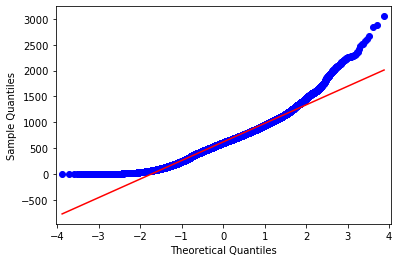

In [14]:
#We perform a qq plot then
sm.qqplot(hw_bcovid.headway, line='s') #.loc[hw_bcovid.hw_pos.isin([3,4])]
pylab.show()

In [15]:
#As the size of our data is bigger than 5000, Shapiro-Test will almost always reject the Null Hypothesis
stats.shapiro(hw_wcovid.headway)

(0.9952864646911621, 1.2302749667133949e-23)

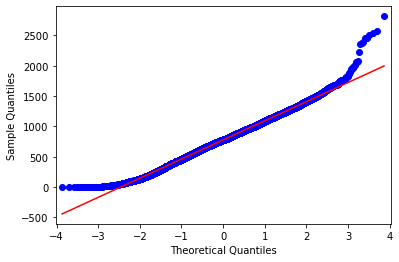

In [16]:
#We perform a qq plot then
sm.qqplot(hw_wcovid.headway, line='s') #.loc[hw_bcovid.hw_pos.isin([3,4])]
pylab.show()

In [17]:
welch_ttest(hw_bcovid.headway,hw_wcovid.headway)

(-44.45910276609286, 0.0)

## P-Values between all possible combinations of day and hour

In [18]:
def get_day_hour_pvalues(df):
    lines_dfs = {}
    lines = ['1','44','82','F','G','U','132','133']
    weekdays = range(7)
    hours = range(7,23)
    for line in lines :
        df_line = df.loc[df.line == line]
        row_list = []
        for weekday1 in weekdays :
            for hour1 in hours :
                df_hour1 = df_line.loc[(df_line.datetime.dt.weekday == weekday1) & (df_line.datetime.dt.hour == hour1)]
                row = {}
                row['Index'] = str(weekday1) + '-' + str(hour1)
                if df_hour1.shape[0] > 0 :
                    for weekday2 in weekdays :
                        for hour2 in hours :
                            df_hour2 = df_line.loc[(df_line.datetime.dt.weekday == weekday2) & (df_line.datetime.dt.hour == hour2)]
                            if df_hour2.shape[0] > 0 :
                                t,p = welch_ttest(df_hour1.headway,df_hour2.headway)
                            else :
                                p = 0.0000
                            
                            name = str(weekday2) + '-' + str(hour2)
                            row[name] = p
                
                row_list.append(row)
        
        lines_dfs[line] = pd.DataFrame(row_list).set_index('Index')
        
    return lines_dfs

hws = headways.loc[(headways.hw_pos != 0) & (headways.datetime < covid_start)]
hw_pvalues = get_day_hour_pvalues(hws)                 

In [19]:
line = '1'

fig = go.Figure(data=go.Heatmap(
   z=[row for row in hw_pvalues[line].itertuples()],
   x=hw_pvalues[line].columns,
   y=hw_pvalues[line].index,
   hoverongaps = False
))
fig.update_layout(
    title = 'P-Values when comparing the mean headway for every (weekday-hour) pair in line {}.'.format(line),
    height = 900
)
fig.show()

In [20]:
def pvalue_based_sel (df,pvalues_df,line,name,threshold) :
    df = df.loc[df.line == line]
    
    def high_pvalue_groups(row) :
        if row >= threshold :
            return row
    
    hw_name = pvalues_df[line].loc[name]
    hw_above = hw_name.apply(high_pvalue_groups).dropna()
    above_thres = hw_above.index.tolist()
    
    dfs = []
    for weekday_hour in above_thres :
        weekday,hour = weekday_hour.split('-')
        wh_df = df.loc[(df.datetime.dt.weekday == int(weekday)) & (df.datetime.dt.hour == int(hour))]
        if wh_df.shape[0] > 0 :
            dfs.append(wh_df)
            
    return pd.concat(dfs),above_thres

line = '1'
name = '0-10'
threshold = 0.3
hws_p,above_threshold = pvalue_based_sel(hws,hw_pvalues,line,name,threshold)
above_threshold

['0-10',
 '0-13',
 '0-19',
 '1-10',
 '1-12',
 '3-12',
 '3-13',
 '3-14',
 '4-10',
 '4-13']

## Selection of headways to analyse

In [43]:
#Data selection attributes
line = '1'
day_type = 'LA'
day_interval = 0
st_hour = 7 #freq_ranges_dict[line][day_type][day_interval]['time_range'][0]
end_hour = 11 #freq_ranges_dict[line][day_type][day_interval]['time_range'][1]
#headway_low = freq_ranges_dict[line][day_type][day_interval]['freq_range'][0]*60
#headway_high = freq_ranges_dict[line][day_type][day_interval]['freq_range'][1]*60

#Data selection eliminating first element of each list cause it belongs to the first bus, no headway value.
hws = headways.loc[(headways.line == line) & \
                (headways.datetime.dt.weekday.isin(day_type_dict[day_type])) & \
                (headways.datetime.dt.hour>=st_hour) & (headways.datetime.dt.hour<end_hour) & \
                (headways.hw_pos != 0) & \
                (headways.headway < 3600)]

In [44]:
#Mean and standard deviation
std_val = hws.headway.std()
mean_val = hws.headway.mean()

#Confidence interval for 70% values inside 
conf = 0.8
ci = stats.norm.interval(conf, loc=mean_val, scale=std_val)

In [45]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=hws.headway,name='Before COVID-19',
    histnorm='probability',
    xbins=dict(
        size=10
    )
))

for val in ci :
    fig.add_shape(
        type='line',
        x0=val,
        y0=0,
        x1=val,
        y1=0.025,
        line=dict(
            color='red',
            width=1.5,
            dash='dashdot'
        )
    )

# Layout
fig.update_layout(
    title='Headways between buses in line {}, in {} days from {}:00 to {}:00.'.format(line,day_type,st_hour,end_hour),
    xaxis_title='Seconds',
    yaxis_title='Normalized Count'
)

## Normality test of the data

In [24]:
#As the size of our data is bigger than 5000, Shapiro-Test will almost always reject the Null Hypothesis
stats.shapiro(hws.headway)

(0.9879458546638489, 1.2611686178923354e-43)

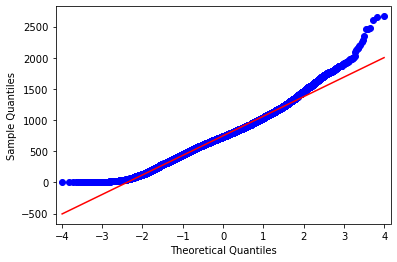

In [25]:
#We perform a qq plot then
sm.qqplot(hws.headway, line='s')
pylab.show()

## 2Dimensional Headways Plot

In [26]:
#2 Dimensional Data Building
hws_2d = headways_2d(hws)
hws_2d.head()

time  busA  busB  busC   h12  h23
0 2020-02-26 09:24:08.435289   124   120  8321  2024  575
1 2020-02-26 09:24:08.435289   123   119   122  1478   78
2 2020-02-26 09:24:08.435289   120  8321   116   575  165
3 2020-02-26 09:24:08.435289   119   122   118    78  558
4 2020-02-26 09:26:18.381947   120  8321   116   588   90

In [27]:
#Get confidence ellipse params
conf = 0.8
ellipse_params = conf_ellipse_params(hws_2d,conf)
mus,ei_vecs,ei_vals = ellipse_params

def inside_apply_2d(row) :
    return int(inside(ellipse_params,row.h12,row.h23))

hws_2d['inside'] = hws_2d.apply(inside_apply_2d,axis=1)
ins_percent = round(hws_2d.inside.mean()*100,1)

In [28]:
#Draw confidence ellipse
fig = go.Figure()
x, y = ellipse(
    mus=mus, 
    ei_vecs=ei_vecs,
    ei_vals=ei_vals
)

#Scatter points
fig.add_trace(go.Scatter(
    name='2D Headways',
    x=hws_2d.h12,
    y=hws_2d.h23,
    mode='markers',
    marker=dict(
        color=['green' if ins_ellip else 'black' for ins_ellip in hws_2d.inside],
        size=1.5
    )
))

#Confidence ellipse
fig.add_trace(go.Scatter(
    name='{}% Confidence Ellipse'.format(conf*100),
    x=x,
    y=y,
    mode='lines',
    line=dict(
        color='orange'
    )
))

#Update the layout
fig.update_layout(
    title='2 Dimensional Headways. {}% points inside. Black points are outside.'.format(ins_percent),
    showlegend=True
)
fig.show()

## Time series analysis of the headways
We can also detect anomalies by detecting strange behaviours in the headway along time.

In [29]:
busA = hws.iloc[0].busA
busB = hws.iloc[0].busB
hw_AB1 = hws.loc[(hws.busA==busA)&(hws.busB==busB)]
hw_AB1.head()

line  direction                   datetime  hw_pos  busA  busB  headway  \
841      1          1 2020-02-26 09:24:08.435289       1   124   120     2024   
45377    1          1 2020-03-04 07:45:55.929352       2   124   120      786   
45384    1          1 2020-03-04 07:46:50.805885       2   124   120      650   
45391    1          1 2020-03-04 07:47:45.991256       2   124   120      656   
45398    1          1 2020-03-04 07:48:41.018762       2   124   120      639   

       busB_ttls  
841         2206  
45377       2721  
45384       2586  
45391       2500  
45398       2438

In [30]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x = hw_AB1.datetime,
    y = hw_AB1.headway,
    mode = 'lines+markers',
    line = dict(
        color = 'blue',
        width = 1.5
    )
))
fig.show()

# Time Series and 1D model combination
Now we are going to see how the 2Dimensional points move along the model.

In [31]:
def add_series_id_1d(df):
    #Ids and series dfs
    series_id = 0
    series_dfs = []
    
    #Obtain unique bus groups
    unique_groups = df[['busA','busB']].drop_duplicates()
    busesA = unique_groups.busA.tolist()
    busesB = unique_groups.busB.tolist()
    
    #Iterate over unique groups
    for k in range(len(busesA)) :
        busA,busB = busesA[k],busesB[k]
        
        #Find all the rows for that bus group
        group_df = df.loc[(df.busA == busA) & (df.busB == busB)]
        group_df = group_df.sort_values(by='datetime')
        
        #Divide the rows into temporal series, splitting them when the time difference is higher than 5 mins
        last_time = group_df.iloc[0].datetime
        last_index = 0
        for i in range(group_df.shape[0]) :
            seconds_diff = (group_df.iloc[i].datetime - last_time).total_seconds()
            last_time = group_df.iloc[i].datetime
            if (seconds_diff > 600) or (i==group_df.shape[0]-1) :
                series_df = group_df.iloc[last_index:i]
                #Assign arrival time and trip day
                series_df = series_df.assign(
                    series_id=series_id
                )
                series_dfs.append(series_df)
                series_id += 1
                last_index = i
                
    return pd.concat(series_dfs)[['datetime','series_id','busA','busB','headway']].reset_index(drop=True)

hws_1d = add_series_id_1d(hws)

In [32]:
#Confidence interval
ci

(344.88486919020573, 1150.1349110295744)

In [46]:
#For 1d
def inside_apply_1d(row) :
    return int(ci[0] <= row.headway <= ci[1])

def series_inside_1d(df,threshold):
    series_dfs = []
    series_inside = 0
    #For each series id
    for i in range(df.series_id.max()+1) :
        series_df = df.loc[df.series_id == i]
        if series_df.shape[0] > 0 :
            inside = series_df.apply(inside_apply_1d,axis=1)
            ins_mean = inside.mean()
            if ins_mean > threshold :
                series_df = series_df.assign(
                    inside = 1
                )
                series_inside+=1
            else :
                series_df = series_df.assign(
                    inside = 0
                )
            series_dfs.append(series_df)
    ins_percent = round(100*series_inside/(df.series_id.max()+1),2)
    return pd.concat(series_dfs),ins_percent

hws_1d,ins_percent = series_inside_1d(hws_1d,0.7)

In [47]:
hws_1d.series_id.value_counts()

520     56
73      56
799     56
117     55
649     55
        ..
1205     1
294      1
342      1
1206     1
0        1
Name: series_id, Length: 1206, dtype: int64

In [48]:
series_count = hws_1d.series_id.max()+1

fig = go.Figure()

fig.add_trace(go.Histogram(
    x=hws_1d.loc[hws_1d.inside == 1].headway, 
    name='Inside series histogram',
    histnorm='probability',
    xbins=dict(
        size=10
    )
))

fig.add_trace(go.Histogram(
    x=hws_1d.loc[hws_1d.inside == 0].headway, 
    name='Outside series histogram',
    histnorm='probability',
    xbins=dict(
        size=10
    )
))

# Layout
fig.update_layout(
    title='1D Series. {}% of {} series inside.'.format(ins_percent,series_count),
    xaxis_title='Seconds',
    yaxis_title='Normalized Count'
)

fig.show()

# Time Series and 2D model combination
Now we are going to see how the 2Dimensional points move along the model.

## Analisis of the headways as temporal groups instead of points

In [49]:
def add_series_id(df):
    #Ids and series dfs
    series_id = 0
    series_dfs = []
    
    #Obtain unique bus groups
    unique_groups = df[['busA','busB','busC']].drop_duplicates()
    busesA = unique_groups.busA.tolist()
    busesB = unique_groups.busB.tolist()
    busesC = unique_groups.busC.tolist()
    
    #Iterate over unique groups
    for k in range(len(busesA)) :
        busA,busB,busC = busesA[k],busesB[k],busesC[k]
        
        #Find all the rows for that bus group
        group_df = df.loc[(df.busA == busA) & (df.busB == busB) & (df.busC == busC)]
        group_df = group_df.sort_values(by='time').reset_index(drop=True)
        
        #Divide the rows into temporal series, splitting them when the time difference is higher than 5 mins
        last_time = group_df.iloc[0].time
        last_index = 0
        for i in range(group_df.shape[0]) :
            seconds_diff = (group_df.iloc[i].time - last_time).total_seconds()
            last_time = group_df.iloc[i].time
            if (seconds_diff > 600) or (i==group_df.shape[0]-1) :
                series_df = group_df.iloc[last_index:i]
                #Assign arrival time and trip day
                series_df = series_df.assign(
                    series_id=series_id
                )
                series_dfs.append(series_df)
                series_id += 1
                last_index = i
                
    return pd.concat(series_dfs)[['time','series_id','busA','busB','busC','h12','h23']].reset_index(drop=True)

hws_2d = add_series_id(hws_2d)

In [50]:
def series_inside_2d(df,threshold):
    series_dfs = []
    series_inside = 0
    #For each series id
    for i in range(df.series_id.max()+1) :
        series_df = df.loc[df.series_id == i]
        if series_df.shape[0] > 0 :
            inside = series_df.apply(inside_apply_2d,axis=1)
            ins_mean = inside.mean()
            if ins_mean > threshold :
                series_df = series_df.assign(
                    inside = 1
                )
                series_inside+=1
            else :
                series_df = series_df.assign(
                    inside = 0
                )
            series_dfs.append(series_df)
    ins_percent = round(100*series_inside/(df.series_id.max()+1),2)
    return pd.concat(series_dfs),ins_percent

hws_2d,ins_percent = series_inside_2d(hws_2d,0.7)          

In [51]:
hws_2d.describe()

series_id       busA       busB       busC        h12        h23  \
count  16568.000  16568.000  16568.000  16568.000  16568.000  16568.000   
mean     490.532   1556.451   1606.085   1716.872    712.326    718.349   
std      293.498   3060.906   3100.825   3180.828    303.934    269.591   
min        0.000    102.000    102.000    102.000      0.000      0.000   
25%      238.000    117.000    117.000    117.000    512.000    555.000   
50%      464.000    120.000    120.000    121.000    704.000    720.000   
75%      743.000    124.000    124.000    124.000    900.000    883.000   
max     1044.000   8615.000   8615.000   8615.000   1989.000   2654.000   

          inside  
count  16568.000  
mean       0.791  
std        0.406  
min        0.000  
25%        1.000  
50%        1.000  
75%        1.000  
max        1.000

In [53]:
series_count = hws_2d.series_id.max()+1
#Create figure
fig = go.Figure()

#Select buses group to see over time
for i in range(series_count) :
    #Get series data
    series_df = hws_2d.loc[hws_2d.series_id == i]
    if series_df.shape[0] < 1 :
        continue
    inside_val = series_df.iloc[0].inside
    color = 'green' if inside_val == 1 else 'black'
    
    if False :
        #Plot trace
        fig.add_trace(go.Scatter(
            showlegend=False,
            name=i,
            x = series_df.h12,
            y = series_df.h23,
            mode = 'lines+markers',
            line = dict(
                color = color,
                width = 1.5
            )
        ))
    
    if inside_val == 1 :
        #Plot trace
        fig.add_trace(go.Scatter(
            showlegend=False,
            name=i,
            x = series_df.h12,
            y = series_df.h23,
            mode = 'lines+markers',
            line = dict(
                color = color,
                width = 1.5
            )
        ))

#Confidence ellipse
fig.add_trace(go.Scatter(
    name='{}% Confidence Ellipse'.format(conf*100),
    x=x,
    y=y,
    mode='lines',
    line=dict(
        color='orange'
    )
))

#Update the layout
fig.update_layout(
    title='2 Dimensional Series of Headways. {}% of {} series inside. Black series are outside.'.format(ins_percent,series_count),
    showlegend=True
)
fig.show()

# Generalization of the model for n dimensions with variable parameters.

## Get n dimensional windows data

In [70]:
def get_ndim_hws (df,dim) :
    #Generate names for the columns of the dataframe to be built
    hw_names = ['hw' + str(i) + str(i+1) for i in range(1,dim+1)]
    bus_names = ['bus' + str(i) for i in range(1,dim+2)]
    
    #Columns to build dictionary
    columns = {}
    names = ['datetime'] + bus_names + hw_names
    for name in names:
        columns[name] = []
    
    #Unique datetime identifiers for the bursts
    burst_times = df.datetime.unique()
    for burst_time in burst_times :
        burst_df1 = df.loc[(df.datetime == burst_time) & (df.direction == 1)].sort_values('hw_pos')
        burst_df2 = df.loc[(df.datetime == burst_time) & (df.direction == 2)].sort_values('hw_pos')
        
        for i in range(max(burst_df1.shape[0],burst_df2.shape[0]) - (dim-1)) :
            if i < (burst_df1.shape[0] - (dim-1)) :
                columns['datetime'].append(burst_time)
                columns[bus_names[0]].append(burst_df1.iloc[i].busA)
                for k in range(dim):
                    columns[hw_names[k]].append(burst_df1.iloc[i+k].headway) 
                    columns[bus_names[k+1]].append(burst_df1.iloc[i+k].busB) 
                    
            if i < (burst_df2.shape[0] - (dim-1)) :
                columns['datetime'].append(burst_time)
                columns[bus_names[0]].append(burst_df2.iloc[i].busA)
                for k in range(dim):
                    columns[hw_names[k]].append(burst_df2.iloc[i+k].headway) 
                    columns[bus_names[k+1]].append(burst_df2.iloc[i+k].busB) 

    return pd.DataFrame(columns)

datetime  bus1  bus2  bus3  bus4  bus5  hw12  hw23  \
0    2020-02-26 09:32:48.384766   122   119   118  8321   121    19   574   
1    2020-02-26 09:34:58.522370   122   119   118  8321   121    50   512   
2    2020-02-26 09:37:08.445637  8321   120   116  8322   123   850   708   
3    2020-02-26 09:37:08.445637   122   119   118   121   124    40   553   
4    2020-02-26 09:39:18.359855  8321   120   116  8322   123   875   684   
...                         ...   ...   ...   ...   ...   ...   ...   ...   
1493 2020-04-03 08:58:20.990057   120   122   119   116   117   568  1143   
1494 2020-04-03 08:59:10.984717   120   122   119   116   117   562  1118   
1495 2020-04-07 08:24:17.405669   123   116   118   120   122   734   940   
1496 2020-04-07 09:03:27.483565   122   120   121   119   117   788   633   
1497 2020-04-07 09:04:17.479255   122   120   121   119   117   873   617   

      hw34  hw45  
0      397   363  
1      417   464  
2      497   734  
3      814   507  
4      451   749  
...    ...   ...  
1493   230   735  
1494   261   717  
1495   785   194  
1496   889   224  
1497   770   228  

[1498 rows x 10 columns]

In [107]:
max_dim = 3
#Paralelizable
dfs = [get_ndim_hws(hws,dim).iloc[:,-dim:] for dim in range(1,max_dim+1)]

In [135]:
dfs[0].head()

hw12
0  2024
1  1478
2   575
3    78
4   165

## Get models for every n dimensional dataframe

In [139]:
def get_models(dfs,conf) :
    models = []
    max_dim = len(dfs)
    #Obtains covariance matrix and threshold Malahanobis Distance for each model
    for dim in range(1,max_dim+1) :
        #Check if dataframes dimensions match or if they are empty
        if dfs[dim-1].shape[1] != dim :
            return 'DataFrame index {} has {} dimensions, {} expected.'.format(dim-1,dfs[dim-1].shape[1],dim)
        if dfs[dim-1].shape[0] < 1 :
            return 'DataFrame index {} is empty'.format(dim-1)
        
        #Get columns from df
        cols = [dfs[dim-1].iloc[:,k] for k in range(dim)]
        
        #Get the covariance matrix of the data
        cov_matrix = np.cov(np.stack(cols, axis = 0))
        #Get Mahalanobis distance from which a certain percentage of the data is out
        mahalanobis_threshold = math.sqrt(chi2.ppf(conf[dim-1], df=dim))
        
        #Append model parameters to models list
        models.append({
            'cov_matrix' : cov_matrix,
            'm_th' : mahalanobis_threshold
        })
    return models

In [140]:
models = get_models(dfs,conf)

In [141]:
models[2]

{'cov_matrix': array([[ 88467.14944348, -28103.67207692,  -4760.22730468],
        [-28103.67207692,  79770.05348682, -17846.41729096],
        [ -4760.22730468, -17846.41729096,  65356.58739273]]),
 'm_th': 2.5002777108094065}

## Test the models built

In [ ]:
def test_model(model,n_out_th,conf):
    #Try model and determine how many ouliers have been detected, as well as the percentage of the total 
    #points that have been tagged as outliers.

In [ ]:
#HYPERPARAMETERS
#Number of consecutive values over Mahalanobis distance to consider we have an outlier
n_out_th = [3,3,3]
#Confidence for each dimension
conf = [0.9,0.9,0.9]